# ショックを含む画像の潜在ベクトルの分布を見る

In [1]:
import importlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
from pprint import pprint
import sklearn
from sklearn import datasets
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering
from sklearn.manifold import TSNE, MDS, SpectralEmbedding
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial import distance
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
sys.path.append("/home/kwk/share/mizuho/u00257/vae_clustering/src/")
sys.path.append("/home/kwk/share/mizuho/u00257/vae_clustering/src/lib/")
sys.path.append("/home/kwk/share/mizuho/u00257/vae_clustering/src/data_pkls/")

In [3]:
from vae_datasets import dataset2d
from vae_models import ConvVAE_224
import img_shows
importlib.reload(img_shows)
from img_shows import *

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
data_pkls = "../data_pkls/imgs224_40_123m/"
pkl_files = [data_pkls + str(i+1) + ".pkl" for i in range(10, 30)]
dataset2 = dataset2d(pkl_files)
print(len(dataset2))
dataloader2 = torch.utils.data.DataLoader(dataset2, batch_size=1, shuffle=False, drop_last=False)

28933


In [6]:
data_pkls = "../data_pkls/"
dates = None
with open(data_pkls + "dates123m.pkl", "rb") as pkl:
    dates = pickle.load(pkl)
print(len(dates))

43446


In [7]:
len1 = 14513
pos2 = 28994
len2 = pos2 - len1
len3 = len(dates) - pos2
print(len1, len2, len3)
print(len(dates))

14513 14481 14452
43446


In [8]:
dates = dates[len1:]
print(len(dates))

28933


### train_lsの可視化(向こうで死んでしまったため)

In [9]:
train_ls = None
with open("../trains/train_ls.pkl", "rb") as pkl:
    train_ls = pickle.load(pkl)

In [10]:
def plot_results(result, which_result, condition, save_or_not=True):
    plt.clf()
    plt.plot(result)
    plt.title(condition + "_" + which_result)
    plt.savefig(condition + "_" + which_result + ".png") if save_or_not else plt.show()

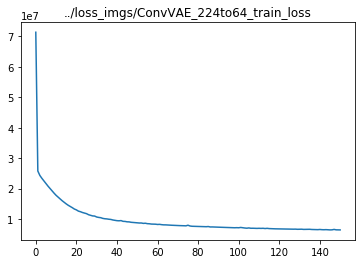

In [11]:
loss_img_path = "../loss_imgs/"
condition = "ConvVAE_224to64"
plot_results(train_ls, "train_loss", loss_img_path + condition)

## ConvVAE_224の潜在ベクトル抽出

In [12]:
model = ConvVAE_224(224)
model.load_state_dict(torch.load("../model_pths/ConvVAE_224.pth"))
model.eval()
model.to(device)

ConvVAE_224(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(16, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv6): Conv2d(512, 1024, kernel_size=(7, 7), stride=(1, 1))
  (conv_mean): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv_var): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
  (t_conv7): ConvTranspose2d(64, 1024, kernel_size=(1, 1), stride=(1, 1))
  (t_conv6): ConvTranspose2d(1024, 512, kernel_size=(7, 7), stride=(1, 1))
  (t_conv5): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2))
  (t_conv4): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
  (t_conv3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
  (t_conv2): ConvTranspose2d(64

In [14]:
orig_hidden_vecs = []
orig_hidden_mus = []
with torch.no_grad():
    for i, (date, batch_imgs) in tqdm(enumerate(zip(dates, dataloader2))):
        mu, logvar = model.encoder(batch_imgs)
        # print(mu.shape, logvar.shape)
        orig_hidden_mus.append(mu.to("cpu").numpy())
        z = model.reparameterize(mu, logvar)
        # print(z.shape)
        z = z.to("cpu").numpy()
        orig_hidden_vecs.append(z)

28933it [03:34, 134.62it/s]


In [15]:
data_size = len(dates)

In [16]:
orig_hidden_vecs = np.array(orig_hidden_vecs)
orig_hidden_mus = np.array(orig_hidden_mus)
print(orig_hidden_vecs.shape)
print(orig_hidden_mus.shape)
hidden_vecs = orig_hidden_vecs.reshape(data_size, 64)
hidden_mus = orig_hidden_mus.reshape(data_size, 64)
print(hidden_vecs.shape)
print(hidden_mus.shape)

(28933, 1, 64, 1, 1)
(28933, 1, 64, 1, 1)
(28933, 64)
(28933, 64)


In [17]:
data_pkls = "../data_pkls/hidden_vecs/"
with open(data_pkls + "hidden_vecs64_convvae224.pkl", "wb") as f:
    pickle.dump(hidden_vecs, f)
with open(data_pkls + "hidden_mus64_convvae224.pkl", "wb") as f:
    pickle.dump(hidden_mus, f)

In [18]:
with open(data_pkls + "hidden_mus64_convvae224.pkl", "rb") as f:
    hidden_mus = pickle.load(f)

## k-meansでクラスタリング: 日付が近いものを除外したい

In [19]:
indices = np.array(list(range(data_size))[::30])
print(indices.shape)

(965,)


In [20]:
num_clusters = 20
s_clustering = KMeans(n_clusters=num_clusters, random_state=10).fit(hidden_mus[indices])
s_labels = s_clustering.labels_

In [22]:
v_label = 10
np.where(s_labels==v_label)[0]

array([ 37,  38, 111, 114, 158, 176, 177, 178, 179, 212, 217, 218, 291,
       295, 383, 385, 418, 519, 520, 534, 594, 597, 599, 640, 658, 660,
       661, 700, 704, 705, 721, 777, 779, 780, 795, 847, 923, 947, 962])

In [23]:
poses = indices[np.where(s_labels==v_label)[0]]

<Figure size 432x288 with 0 Axes>

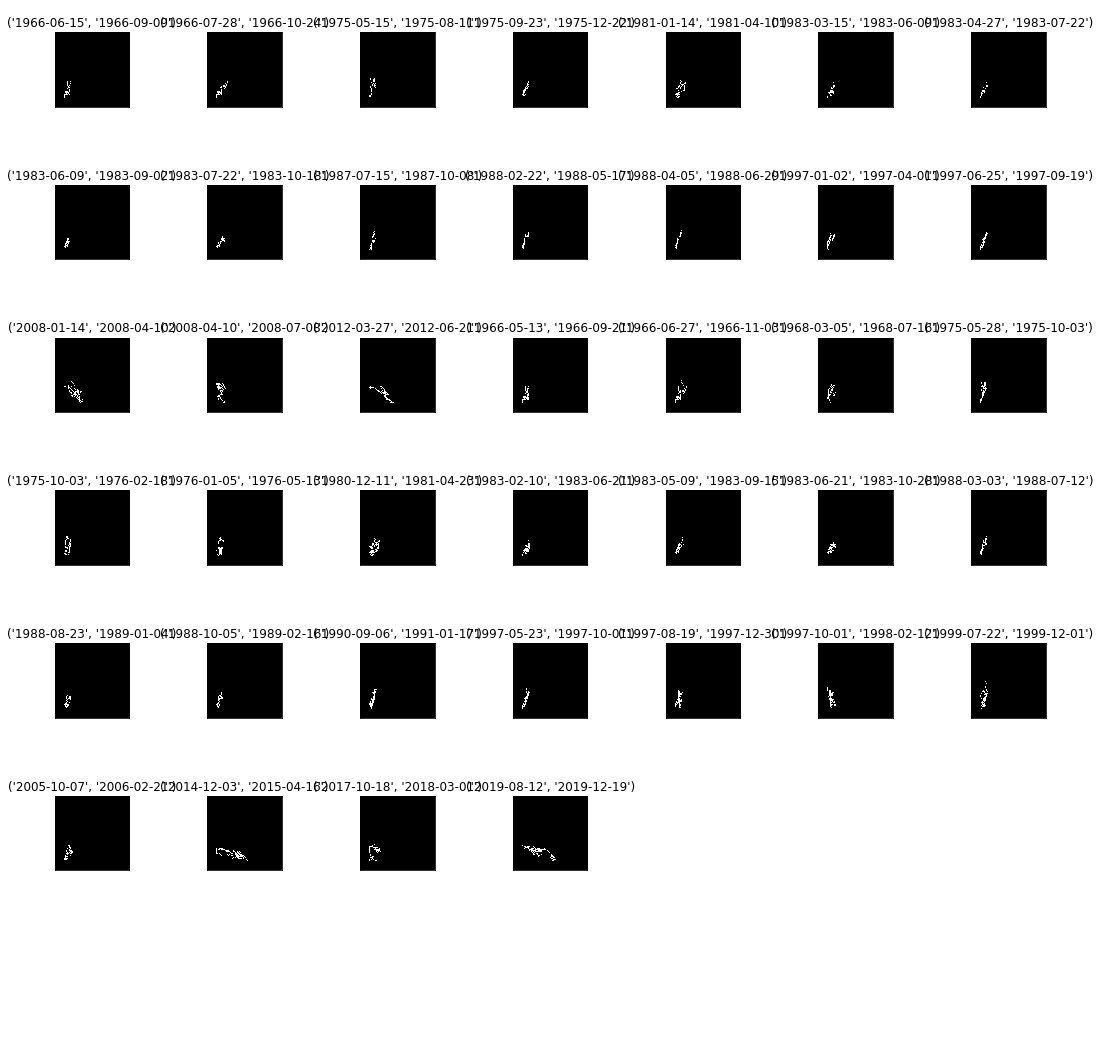

In [24]:
imshow(dataset2, dates, poses)

## 4次元潜在ベクトルをt-SNEで2次元へ

In [25]:
points = TSNE(n_components=2, random_state=0).fit_transform(hidden_mus[indices])

<Figure size 432x288 with 0 Axes>

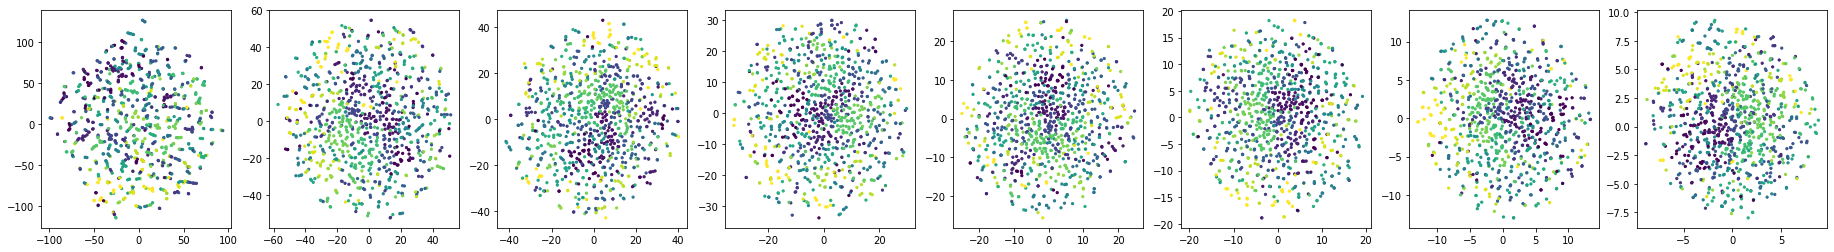

In [26]:
perplexities = [5,25,45, 65,85,105,125,145]
visualize_zsp(hidden_mus[indices], perplexities, labels=s_labels)

<Figure size 432x288 with 0 Axes>

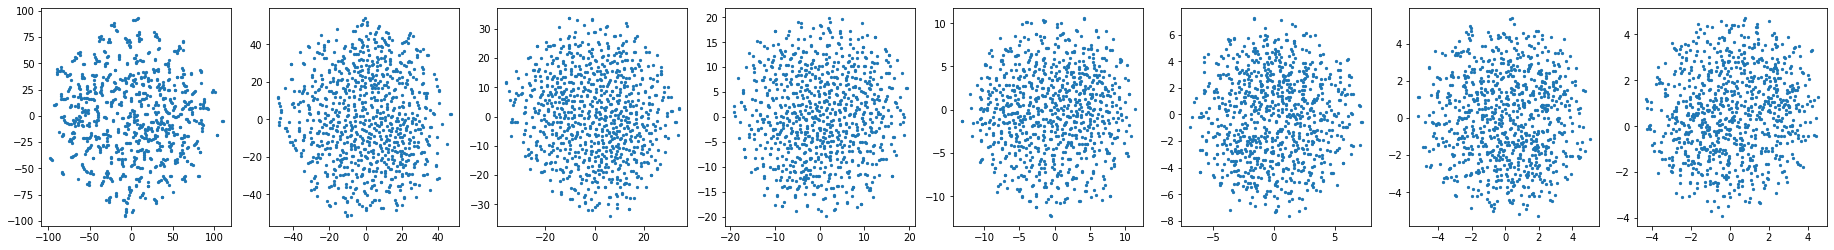

In [28]:
visualize_zsp(hidden_mus[indices], perplexities)

In [66]:
tsne_points = TSNE(n_components=2, random_state=0, perplexity=5, n_iter=2000).fit_transform(hidden_mus[indices])

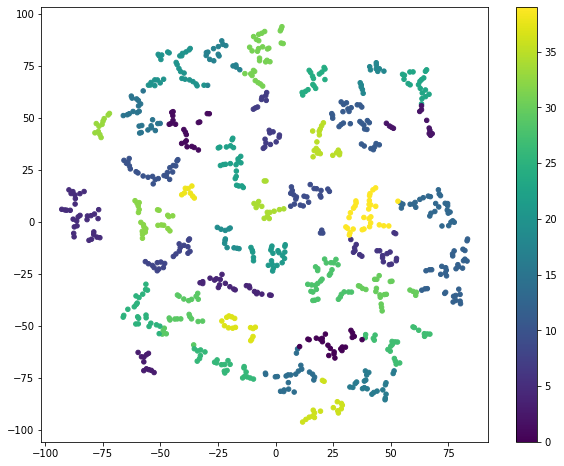

In [112]:
num_clusters = 40 
tsne_kmeans = KMeans(n_clusters=num_clusters, random_state=10).fit(tsne_points)
tsne_labels = tsne_kmeans.labels_
plt.figure(figsize=(10,8))
plt.clf()
plt.scatter(tsne_points[:, 0], tsne_points[:, 1], c=tsne_labels, s=20)
plt.colorbar()

In [107]:
mds_points = MDS(n_components=2, random_state=0).fit_transform(hidden_mus[indices])

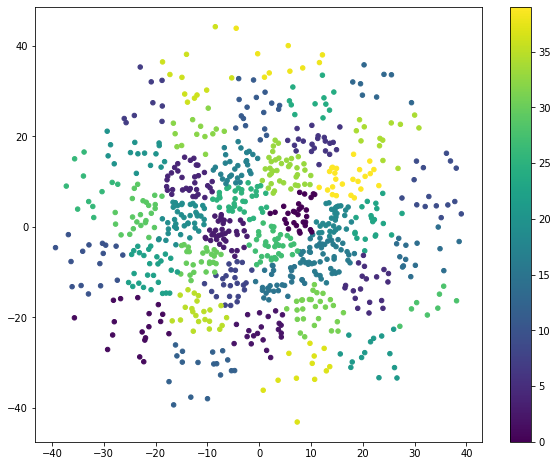

In [110]:
num_clusters = 40 
mds_kmeans = KMeans(n_clusters=num_clusters, random_state=10).fit(mds_points)
mds_labels = mds_kmeans.labels_
plt.figure(figsize=(10,8))
plt.clf()
plt.scatter(mds_points[:, 0], mds_points[:, 1], c=mds_labels, s=20)
plt.colorbar()

In [108]:
se_points = SpectralEmbedding(n_components=2, random_state=0).fit_transform(hidden_mus[indices])

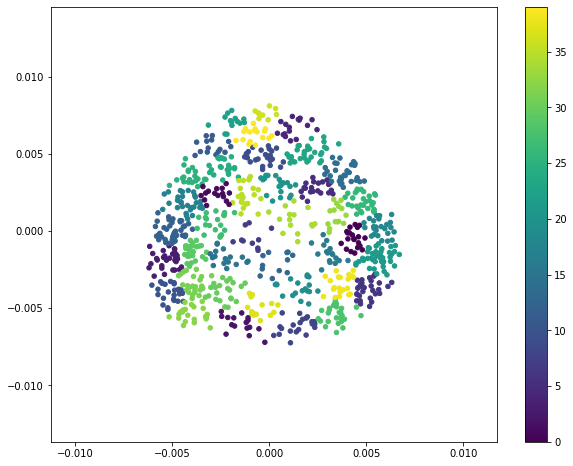

In [111]:
num_clusters = 40 
se_kmeans = KMeans(n_clusters=num_clusters, random_state=10).fit(se_points)
se_labels = se_kmeans.labels_
plt.figure(figsize=(10,8))
plt.clf()
plt.scatter(se_points[:, 0], se_points[:, 1], c=se_labels, s=20)
plt.colorbar()

In [118]:
np.where(tsne_labels==tsne_labels[0])

(array([  0,  43,  59,  70,  88,  92, 107, 118, 123, 128, 143, 145, 159,
        164, 166, 177, 204, 247, 264, 295, 355, 369, 394, 397, 402, 449,
        481, 508, 527, 580, 774, 775]),)

In [119]:
np.where(mds_labels==mds_labels[0])

(array([  0,  40,  59,  63,  90, 116, 118, 186, 207, 258, 273, 299, 311,
        312, 319, 329, 362, 367, 377, 381, 392, 428, 433, 442, 467, 474,
        475, 488, 490, 491, 511, 518, 524, 528, 535, 561, 564, 580, 621,
        680, 838]),)

In [120]:
np.where(se_labels==se_labels[0])

(array([  0,  24,  63, 107, 128, 129, 176, 208, 238, 255, 278, 289, 330,
        347, 374, 379, 380, 405, 407, 477, 484, 498, 499, 512, 534, 536,
        556, 621, 658]),)

## 最も近いものを取ってくる

In [27]:
import heapq
class priority_queue:
    def __init__(self):
        self.key = lambda item: item[0] #アイテムの優先順位を指定
        self.index = 0
        self.data = []

    def push(self, item):
        heapq.heappush(self.data, (self.key(item), self.index, item))
        self.index += 1

    def pop(self):
        return heapq.heappop(self.data)[1]

In [28]:
def get_nearest(pos, hidden_vecs, n = 10):
    t_vec = hidden_vecs[pos]
    pq = priority_queue()
    for i, vec in enumerate(hidden_vecs):
        dist = distance.euclidean(t_vec, vec)
        pq.push([dist, i])
    n_poses = []
    for i in range(n + 1):
        n_poses.append(pq.pop())
    return n_poses[1:]

In [36]:
p = 800
pos = indices[p]
n = 4

<Figure size 432x288 with 0 Axes>

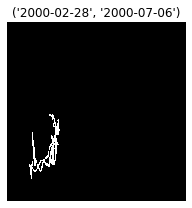

In [37]:
imshow(dataset2, dates, [pos], figsize = (3,3))

[ 9540 24030  1140  6300]


<Figure size 432x288 with 0 Axes>

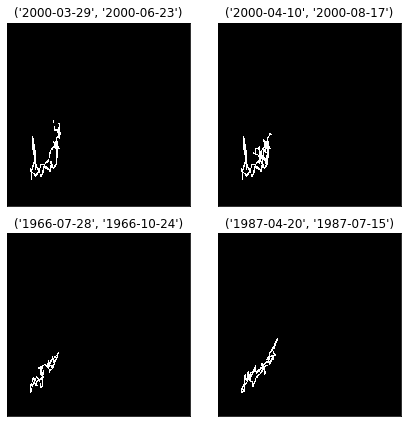

In [38]:
ps = get_nearest(p, hidden_mus[indices], n)
print(indices[ps])
imshow(dataset2, dates, indices[ps], figsize=(6,6))

In [32]:
ps = get_nearest(p, tsne_points, n)
print(indices[ps])
imshow(dataset2, dates, indices[ps], figsize=(6,6))

NameError: name 'tsne_points' is not defined

<Figure size 432x288 with 0 Axes>

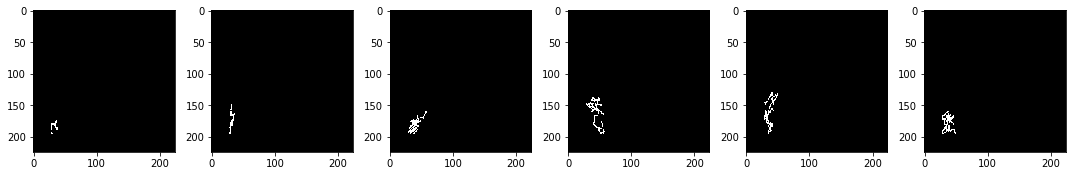

In [43]:
poses = [i * 4000 for i in range(6)]
imshow_conv(dataset2, poses)

<Figure size 432x288 with 0 Axes>

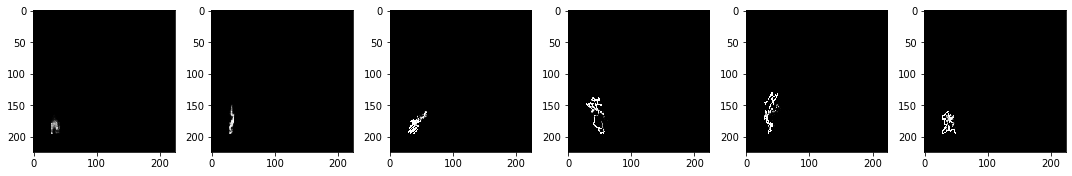

In [46]:
imshow_conv(dataset2, poses, model=model, device=device)

In [47]:
num_clusters = 20
label_clustering = KMeans(n_clusters=num_clusters, random_state=10).fit(hidden_mus)
label_clustering.labels_

array([ 6,  6,  6, ..., 13, 13, 13], dtype=int32)

In [49]:
print(label_clustering.labels_.shape)

(28933,)


In [48]:
data_pkls = "../data_pkls/labels/"
with open(data_pkls + "labels20_23m.pkl", "wb") as f:
    pickle.dump(label_clustering.labels_, f)

## 絶対位置をどうにかしたいよね

## 変更点

- データを変更？
- モデルを変更 ?
- クラスタリング手法を変更?